In [3]:
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import keras_tuner as kt

In [7]:
path = "/kaggle/input/weed-detection-in-soybean-crops/dataset"
classes = ["broadleaf", "grass", "soil", "soybean"]
IMG_SIZE = 32

In [8]:
def load_imgs(dir):
    data = []
    gt = []
    for i in dir:
        images = os.listdir(path + '/' + i)
        for img in images:
            im = Image.open(path + '/' + i + '/' + img).convert('RGB')
            im = im.resize((IMG_SIZE, IMG_SIZE))
            data.append(np.array(im))
            gt.append(i)
    return np.array(data), gt

In [9]:
X, y = load_imgs(classes)
X = X / 255.0

le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y, num_classes=4)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [10]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(2048).batch(64).prefetch(1)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(64).prefetch(1)

I0000 00:00:1763117665.504006      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763117665.504648      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [11]:
def build_cnn(hp):
    model = keras.Sequential()

    model.add(layers.Conv2D(
        filters=hp.Choice("filters1", [16, 32, 64]),
        kernel_size=hp.Choice("kernel1", [3, 5]),
        activation="relu",
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    ))
    model.add(layers.MaxPooling2D())

    model.add(layers.Conv2D(
        filters=hp.Choice("filters2", [32, 64, 128]),
        kernel_size=hp.Choice("kernel2", [3, 5]),
        activation="relu"
    ))
    model.add(layers.MaxPooling2D())

    model.add(layers.Flatten())

    model.add(layers.Dense(
        hp.Choice("dense_units", [64, 128, 256]),
        activation="relu"
    ))

    model.add(layers.Dropout(hp.Choice("dropout", [0.2, 0.3, 0.4])))

    model.add(layers.Dense(4, activation="softmax"))

    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

# ============================================
# TUNER
# ============================================
tuner = kt.RandomSearch(
    build_cnn,
    objective="val_accuracy",
    max_trials=5,
    directory="tuning",
    project_name="cnn_weed"
)

tuner.search(train_ds, epochs=5, validation_data=test_ds)

best_cnn = tuner.get_best_models(1)[0]

cnn_history = best_cnn.fit(train_ds, validation_data=test_ds, epochs=10)

Trial 5 Complete [00h 00m 10s]
val_accuracy: 0.9299217462539673

Best val_accuracy So Far: 0.9299217462539673
Total elapsed time: 00h 00m 54s
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


192/192 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9093 - loss: 0.2429 - val_accuracy: 0.8849 - val_loss: 0.2849
Epoch 2/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9179 - loss: 0.2198 - val_accuracy: 0.9355 - val_loss: 0.1783
Epoch 3/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9355 - loss: 0.1790 - val_accuracy: 0.9296 - val_loss: 0.1921
Epoch 4/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9317 - loss: 0.1894 - val_accuracy: 0.9247 - val_loss: 0.1914
Epoch 5/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9357 - loss: 0.1780 - val_accuracy: 0.9299 - val_loss: 0.1747
Epoch 6/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9495 - loss: 0.1443 - val_accuracy: 0.9283 - val_loss: 0.2109
Epoch 7/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9432 - loss: 0.1545 - val_accuracy: 0.9254 - val_loss: 0.1926
Epoch 8/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9527 - loss: 0.1276 - val_accuracy: 0.9430 - val

In [12]:
print("\nCNN Accuracy:", best_cnn.evaluate(test_ds)[1])

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9497 - loss: 0.1480

CNN Accuracy: 0.9468709230422974


In [13]:
# ============================================
# EFFICIENTNETB0
# ============================================
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

base = keras.applications.EfficientNetB0(
    include_top=False,
    weights=None,
    input_tensor=inputs,
    pooling="avg"
)

x = layers.Dense(128, activation="relu")(base.output)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(4, activation="softmax")(x)

eff_model = keras.Model(inputs, outputs)

eff_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

eff_history = eff_model.fit(train_ds, validation_data=test_ds, epochs=10)


Epoch 1/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 109s 231ms/step - accuracy: 0.4383 - loss: 1.3403 - val_accuracy: 0.4811 - val_loss: 1.2757
Epoch 2/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.7081 - loss: 0.7193 - val_accuracy: 0.4811 - val_loss: 1.4822
Epoch 3/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7804 - loss: 0.5321 - val_accuracy: 0.6917 - val_loss: 0.8284
Epoch 4/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8311 - loss: 0.4281 - val_accuracy: 0.7676 - val_loss: 0.5653
Epoch 5/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8500 - loss: 0.3708 - val_accuracy: 0.7862 - val_loss: 0.5123
Epoch 6/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8752 - loss: 0.3246 - val_accuracy: 0.6832 - val_loss: 0.8209
Epoch 7/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8891 - loss: 0.2970 - val_accuracy: 0.7520 - val_loss: 0.7396
Epoch 8/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9134 - loss: 0.2380 - val_a

In [14]:
print("EfficientNetB0 Accuracy:", eff_model.evaluate(test_ds)[1])

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8136 - loss: 0.5055
EfficientNetB0 Accuracy: 0.8174706697463989


In [15]:
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

base = keras.applications.MobileNetV2(
    include_top=False,
    weights=None,
    input_tensor=inputs,
    pooling="avg"
)

x = layers.Dense(128, activation="relu")(base.output)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(4, activation="softmax")(x)

mobile_model = keras.Model(inputs, outputs)

mobile_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

mobile_history = mobile_model.fit(train_ds, validation_data=test_ds, epochs=10)

Epoch 1/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 62s 121ms/step - accuracy: 0.5228 - loss: 1.1749 - val_accuracy: 0.4811 - val_loss: 1.3547
Epoch 2/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7533 - loss: 0.5924 - val_accuracy: 0.4811 - val_loss: 1.3138
Epoch 3/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8320 - loss: 0.4228 - val_accuracy: 0.4811 - val_loss: 1.3238
Epoch 4/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8517 - loss: 0.3701 - val_accuracy: 0.4811 - val_loss: 1.3497
Epoch 5/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8815 - loss: 0.3040 - val_accuracy: 0.4811 - val_loss: 1.4731
Epoch 6/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9003 - loss: 0.2761 - val_accuracy: 0.4811 - val_loss: 1.3436
Epoch 7/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9124 - loss: 0.2436 - val_accuracy: 0.4811 - val_loss: 1.4067
Epoch 8/10
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9229 - loss: 0.2230 - val_ac

In [16]:
print("MobileNetV2 Accuracy:", mobile_model.evaluate(test_ds)[1])

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4904 - loss: 1.5831
MobileNetV2 Accuracy: 0.48109516501426697


In [20]:
cnn_eval = best_cnn.evaluate(test_ds, verbose=0)
eff_eval = eff_model.evaluate(test_ds, verbose=0)
mob_eval = mobile_model.evaluate(test_ds, verbose=0)

model_names = ["CNN (Tuned)", "EfficientNetB0", "MobileNetV2"]
accuracies = [cnn_eval[1], eff_eval[1], mob_eval[1]]
losses = [cnn_eval[0], eff_eval[0], mob_eval[0]]

# Predictions
y_pred_cnn = best_cnn.predict(test_ds)
y_pred_eff = eff_model.predict(test_ds)
y_pred_mob = mobile_model.predict(test_ds)

# Convert to labels
y_true = np.argmax(y_test, axis=1)
pred_cnn = np.argmax(y_pred_cnn, axis=1)
pred_eff = np.argmax(y_pred_eff, axis=1)
pred_mob = np.argmax(y_pred_mob, axis=1)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [23]:
import pandas as pd
df = pd.DataFrame({
    "Model": model_names,
    "Accuracy": accuracies,
    "Loss": losses
})

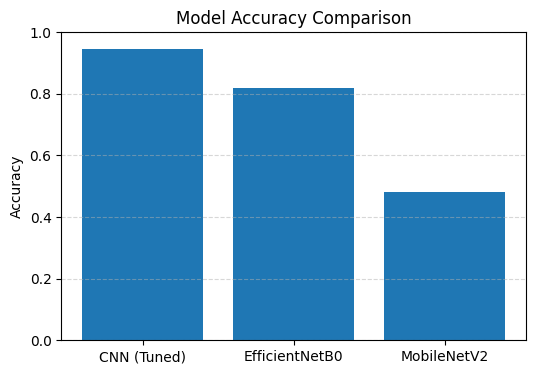

In [24]:
plt.figure(figsize=(6,4))
plt.bar(model_names, accuracies)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

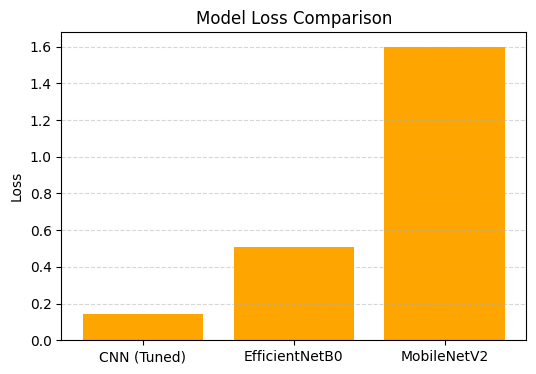

In [25]:
plt.figure(figsize=(6,4))
plt.bar(model_names, losses, color='orange')
plt.title("Model Loss Comparison")
plt.ylabel("Loss")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

In [17]:
y_pred_cnn = best_cnn.predict(test_ds)
y_pred_eff = eff_model.predict(test_ds)
y_pred_mob = mobile_model.predict(test_ds)

# Convert to class labels
y_true = np.argmax(y_test, axis=1)

pred_cnn = np.argmax(y_pred_cnn, axis=1)
pred_eff = np.argmax(y_pred_eff, axis=1)
pred_mob = np.argmax(y_pred_mob, axis=1)

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step


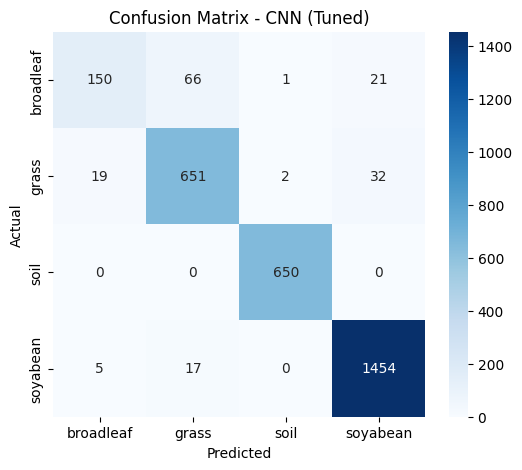

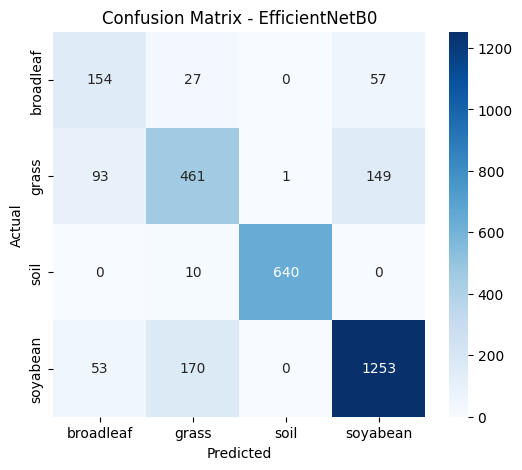

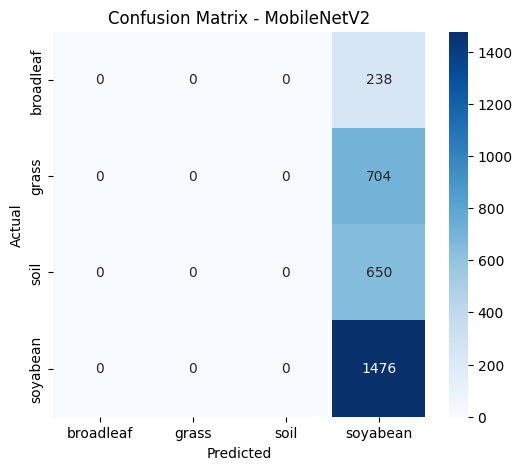

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

labels = ["broadleaf", "grass", "soil", "soyabean"]

def plot_cm(cm, title):
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# CNN
cm_cnn = confusion_matrix(y_true, pred_cnn)
plot_cm(cm_cnn, "Confusion Matrix - CNN (Tuned)")

# EfficientNetB0
cm_eff = confusion_matrix(y_true, pred_eff)
plot_cm(cm_eff, "Confusion Matrix - EfficientNetB0")

# MobileNetV2
cm_mob = confusion_matrix(y_true, pred_mob)
plot_cm(cm_mob, "Confusion Matrix - MobileNetV2")

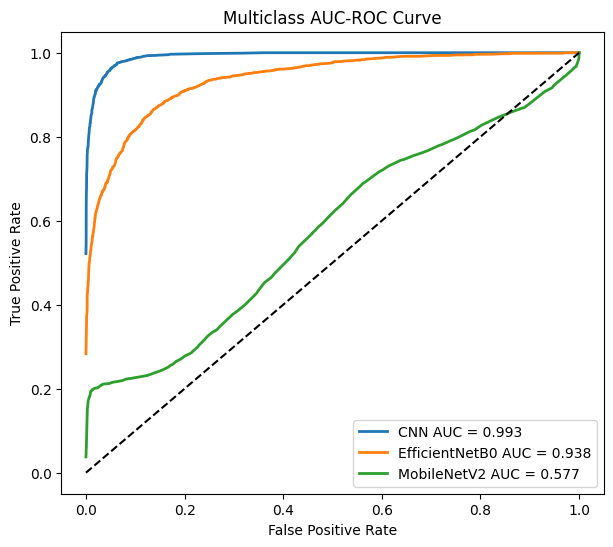

In [19]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize labels for multiclass ROC
y_bin = label_binarize(y_true, classes=[0,1,2,3])

plt.figure(figsize=(7,6))

def plot_roc(y_true_bin, y_pred_prob, model_name):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(4):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Macro average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(4)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(4):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= 4

    macro_auc = auc(all_fpr, mean_tpr)

    plt.plot(all_fpr, mean_tpr,
             label=f"{model_name} AUC = {macro_auc:.3f}", linewidth=2)

# CNN
plot_roc(y_bin, y_pred_cnn, "CNN")

# EfficientNet
plot_roc(y_bin, y_pred_eff, "EfficientNetB0")

# MobileNet
plot_roc(y_bin, y_pred_mob, "MobileNetV2")

plt.plot([0,1],[0,1],'k--')
plt.title("Multiclass AUC-ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()